In [ ]:
# Author: Jack Kelly

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import time
import h5py
import kerastuner as kt
import os
import sys
import pathlib

In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
N_channels = 40
data_path = os.getcwd()

In [4]:
### IMPORT, SHUFFLE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [5]:
file_path = f'{data_path}/Data/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)

In [6]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    hp_regularizer = hp.Choice('regularizer_penalty', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=56, max_value=200, step=4), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [7]:
### CREATE HYPERBAND TUNER ###

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_mean_squared_error', 'min'),
                     max_epochs=100,
                     factor=3,
                     directory=data_path,
                     project_name='tuned_ANN',
                     overwrite=True,
                     seed=8)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

In [8]:
### SEARCHING FOR THE OPTIMAL ANN ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.2, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Trial 254 Complete [00h 00m 15s]
val_mean_squared_error: 0.006523252930492163

Best val_mean_squared_error So Far: 0.00021041565923951566
Total elapsed time: 00h 08m 26s
INFO:tensorflow:Oracle triggered exit
506.7369248867035


In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Tuned model trained for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=100, shuffle=True, validation_split=0.2, verbose=2)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Tuned model trained for optimum number of epochs
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.2, verbose=2)

Epoch 1/100
250/250 - 0s - loss: 0.2009 - mean_squared_error: 0.2006 - mean_absolute_error: 0.4334 - val_loss: 0.1801 - val_mean_squared_error: 0.1798 - val_mean_absolute_error: 0.4057
Epoch 2/100
250/250 - 0s - loss: 0.1529 - mean_squared_error: 0.1527 - mean_absolute_error: 0.3645 - val_loss: 0.1324 - val_mean_squared_error: 0.1322 - val_mean_absolute_error: 0.3296
Epoch 3/100
250/250 - 0s - loss: 0.1171 - mean_squared_error: 0.1169 - mean_absolute_error: 0.3013 - val_loss: 0.1072 - val_mean_squared_error: 0.1069 - val_mean_absolute_error: 0.2840
Epoch 4/100
250/250 - 0s - loss: 0.0951 - mean_squared_error: 0.0948 - mean_absolute_error: 0.2657 - val_loss: 0.0866 - val_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.2529
Epoch 5/100
250/250 - 0s - loss: 0.0762 - mean_squared_error: 0.0759 - mean_absolute_error: 0.2357 - val_loss: 0.0690 - val_mean_squared_error: 0.0687 - val_mean_absolute_error: 0.2244
Epoch 6/100
250/250 - 0s - loss: 0.0602 - mean_squared_error: 0.0599 - mean

Epoch 45/100
250/250 - 0s - loss: 9.6834e-04 - mean_squared_error: 3.3658e-04 - mean_absolute_error: 0.0140 - val_loss: 9.5465e-04 - val_mean_squared_error: 3.2157e-04 - val_mean_absolute_error: 0.0135
Epoch 46/100
250/250 - 0s - loss: 9.5459e-04 - mean_squared_error: 3.2025e-04 - mean_absolute_error: 0.0136 - val_loss: 9.4420e-04 - val_mean_squared_error: 3.0866e-04 - val_mean_absolute_error: 0.0131
Epoch 47/100
250/250 - 0s - loss: 9.4370e-04 - mean_squared_error: 3.0698e-04 - mean_absolute_error: 0.0133 - val_loss: 9.3881e-04 - val_mean_squared_error: 3.0097e-04 - val_mean_absolute_error: 0.0131
Epoch 48/100
250/250 - 0s - loss: 9.3549e-04 - mean_squared_error: 2.9654e-04 - mean_absolute_error: 0.0130 - val_loss: 9.2600e-04 - val_mean_squared_error: 2.8597e-04 - val_mean_absolute_error: 0.0125
Epoch 49/100
250/250 - 0s - loss: 9.3044e-04 - mean_squared_error: 2.8941e-04 - mean_absolute_error: 0.0129 - val_loss: 9.2366e-04 - val_mean_squared_error: 2.8165e-04 - val_mean_absolute_erro

Epoch 86/100
250/250 - 0s - loss: 8.5886e-04 - mean_squared_error: 1.9593e-04 - mean_absolute_error: 0.0103 - val_loss: 8.8307e-04 - val_mean_squared_error: 2.2008e-04 - val_mean_absolute_error: 0.0105
Epoch 87/100
250/250 - 0s - loss: 8.7536e-04 - mean_squared_error: 2.1240e-04 - mean_absolute_error: 0.0106 - val_loss: 8.7370e-04 - val_mean_squared_error: 2.1072e-04 - val_mean_absolute_error: 0.0103
Epoch 88/100
250/250 - 0s - loss: 8.6978e-04 - mean_squared_error: 2.0683e-04 - mean_absolute_error: 0.0105 - val_loss: 8.6381e-04 - val_mean_squared_error: 2.0092e-04 - val_mean_absolute_error: 0.0100
Epoch 89/100
250/250 - 0s - loss: 8.5541e-04 - mean_squared_error: 1.9245e-04 - mean_absolute_error: 0.0102 - val_loss: 8.5971e-04 - val_mean_squared_error: 1.9672e-04 - val_mean_absolute_error: 0.0103
Epoch 90/100
250/250 - 0s - loss: 8.5174e-04 - mean_squared_error: 1.8871e-04 - mean_absolute_error: 0.0101 - val_loss: 8.5716e-04 - val_mean_squared_error: 1.9407e-04 - val_mean_absolute_erro

Epoch 29/98
250/250 - 0s - loss: 0.0016 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0268 - val_loss: 0.0016 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0258
Epoch 30/98
250/250 - 0s - loss: 0.0016 - mean_squared_error: 9.9544e-04 - mean_absolute_error: 0.0255 - val_loss: 0.0015 - val_mean_squared_error: 9.1924e-04 - val_mean_absolute_error: 0.0244
Epoch 31/98
250/250 - 0s - loss: 0.0015 - mean_squared_error: 9.0023e-04 - mean_absolute_error: 0.0242 - val_loss: 0.0014 - val_mean_squared_error: 8.4786e-04 - val_mean_absolute_error: 0.0234
Epoch 32/98
250/250 - 0s - loss: 0.0014 - mean_squared_error: 8.3093e-04 - mean_absolute_error: 0.0231 - val_loss: 0.0013 - val_mean_squared_error: 7.6432e-04 - val_mean_absolute_error: 0.0220
Epoch 33/98
250/250 - 0s - loss: 0.0013 - mean_squared_error: 7.5145e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0013 - val_mean_squared_error: 7.0499e-04 - val_mean_absolute_error: 0.0209
Epoch 34/98
250/250 - 0s - loss: 0.0013 - m

Epoch 71/98
250/250 - 0s - loss: 8.8499e-04 - mean_squared_error: 2.2634e-04 - mean_absolute_error: 0.0111 - val_loss: 9.8041e-04 - val_mean_squared_error: 3.2160e-04 - val_mean_absolute_error: 0.0128
Epoch 72/98
250/250 - 0s - loss: 8.7082e-04 - mean_squared_error: 2.1187e-04 - mean_absolute_error: 0.0108 - val_loss: 9.0566e-04 - val_mean_squared_error: 2.4658e-04 - val_mean_absolute_error: 0.0111
Epoch 73/98
250/250 - 0s - loss: 8.6183e-04 - mean_squared_error: 2.0260e-04 - mean_absolute_error: 0.0105 - val_loss: 8.6596e-04 - val_mean_squared_error: 2.0658e-04 - val_mean_absolute_error: 0.0103
Epoch 74/98
250/250 - 0s - loss: 8.7081e-04 - mean_squared_error: 2.1131e-04 - mean_absolute_error: 0.0108 - val_loss: 8.6703e-04 - val_mean_squared_error: 2.0742e-04 - val_mean_absolute_error: 0.0103
Epoch 75/98
250/250 - 0s - loss: 8.6365e-04 - mean_squared_error: 2.0389e-04 - mean_absolute_error: 0.0106 - val_loss: 8.6778e-04 - val_mean_squared_error: 2.0790e-04 - val_mean_absolute_error: 0.

In [10]:
for key, value in best_hps.__dict__['values'].items():
    print(f'- {key}: {value}')

- regularizer_penalty: 1e-06
- n_layers: 2
- hidden_0_units: 140
- learning_rate: 0.0001
- hidden_1_units: 100
- tuner/epochs: 100
- tuner/initial_epoch: 34
- tuner/bracket: 1
- tuner/round: 1
- tuner/trial_id: 5c534bb8e94434e0320548f194495674


In [11]:
file_path = f'{data_path}/Data/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
print(f'MSE test: {eval_result}')

MSE test: 0.00019442260963842273


In [12]:
def visualising_data_MSE(hist, name):
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

def visualising_data_MAE(hist, name):
    plt.plot(hist.history['mean_absolute_error'], label='Train')
    plt.plot(hist.history['val_mean_absolute_error'], label='Validation')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

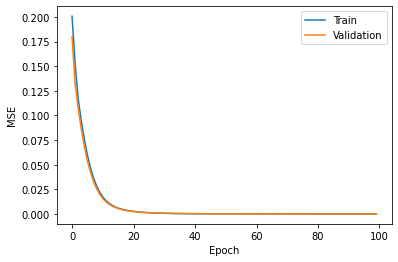

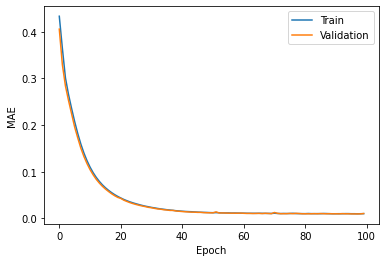

In [13]:
visualising_data_MSE(history, f'{data_path}/Figures/full_epochs_results_MSE.svg')
visualising_data_MAE(history, f'{data_path}/Figures/full_epochs_results_MAE.svg')

In [14]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________


In [15]:
hypermodel.save(f'{data_path}/Tuned_ANN_model.h5')

# Cross-validation

In [16]:
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(140, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-6), input_dim=41))
    model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-6)))
    model.add(keras.layers.Dense(40, activation='sigmoid', kernel_regularizer = tf.keras.regularizers.l2(1e-6)))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

file_path = f'{data_path}/Data/10000_initial_data_testing.csv'
X_data, Y_data = processing_data(N_channels, file_path)
results = []
for i in range(10):
    model = build_model()
    X_train = np.concatenate((X_data[:i*1000],X_data[(i+1)*1000:]))
    Y_train = np.concatenate((Y_data[:i*1000],Y_data[(i+1)*1000:]))
    X_test = X_data[i*1000:(i+1)*1000]
    Y_test = Y_data[i*1000:(i+1)*1000]
    history = model.fit(X_train, Y_train, epochs=100)
    result = model.evaluate(X_test, Y_test, verbose=0)[1]
    results.append(result)
print(results)

Epoch 1/100
282/282 [==============================] - 0s 821us/step - loss: 0.1975 - mean_squared_error: 0.1973 - mean_absolute_error: 0.4302
Epoch 2/100
282/282 [==============================] - 0s 735us/step - loss: 0.1448 - mean_squared_error: 0.1446 - mean_absolute_error: 0.3455
Epoch 3/100
282/282 [==============================] - 0s 780us/step - loss: 0.1134 - mean_squared_error: 0.1132 - mean_absolute_error: 0.2912
Epoch 4/100
282/282 [==============================] - 0s 710us/step - loss: 0.0873 - mean_squared_error: 0.0870 - mean_absolute_error: 0.2533
Epoch 5/100
282/282 [==============================] - 0s 779us/step - loss: 0.0656 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2169
Epoch 6/100
282/282 [==============================] - 0s 828us/step - loss: 0.0490 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1855
Epoch 7/100
282/282 [==============================] - 0s 733us/step - loss: 0.0366 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1586

282/282 [==============================] - 0s 738us/step - loss: 8.8682e-04 - mean_squared_error: 2.3151e-04 - mean_absolute_error: 0.0113
Epoch 57/100
282/282 [==============================] - 0s 720us/step - loss: 8.7651e-04 - mean_squared_error: 2.2057e-04 - mean_absolute_error: 0.0110
Epoch 58/100
282/282 [==============================] - 0s 798us/step - loss: 8.8953e-04 - mean_squared_error: 2.3307e-04 - mean_absolute_error: 0.0113
Epoch 59/100
282/282 [==============================] - 0s 769us/step - loss: 8.8142e-04 - mean_squared_error: 2.2449e-04 - mean_absolute_error: 0.0111
Epoch 60/100
282/282 [==============================] - 0s 717us/step - loss: 8.7833e-04 - mean_squared_error: 2.2096e-04 - mean_absolute_error: 0.0110
Epoch 61/100
282/282 [==============================] - 0s 780us/step - loss: 8.7444e-04 - mean_squared_error: 2.1657e-04 - mean_absolute_error: 0.0109
Epoch 62/100
282/282 [==============================] - 0s 820us/step - loss: 8.7909e-04 - mean_squar

282/282 [==============================] - 0s 731us/step - loss: 0.0153 - mean_squared_error: 0.0149 - mean_absolute_error: 0.1025
Epoch 11/100
282/282 [==============================] - 0s 781us/step - loss: 0.0118 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0900
Epoch 12/100
282/282 [==============================] - 0s 737us/step - loss: 0.0093 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0797
Epoch 13/100
282/282 [==============================] - 0s 766us/step - loss: 0.0075 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0712
Epoch 14/100
282/282 [==============================] - 0s 760us/step - loss: 0.0062 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0640
Epoch 15/100
282/282 [==============================] - 0s 808us/step - loss: 0.0052 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0579
Epoch 16/100
282/282 [==============================] - 0s 837us/step - loss: 0.0044 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0527
Epoch

282/282 [==============================] - 0s 657us/step - loss: 8.6606e-04 - mean_squared_error: 2.1029e-04 - mean_absolute_error: 0.0107
Epoch 66/100
282/282 [==============================] - 0s 662us/step - loss: 8.6716e-04 - mean_squared_error: 2.1103e-04 - mean_absolute_error: 0.0107
Epoch 67/100
282/282 [==============================] - 0s 657us/step - loss: 8.6900e-04 - mean_squared_error: 2.1259e-04 - mean_absolute_error: 0.0107
Epoch 68/100
282/282 [==============================] - 0s 670us/step - loss: 8.7772e-04 - mean_squared_error: 2.2106e-04 - mean_absolute_error: 0.0109
Epoch 69/100
282/282 [==============================] - 0s 689us/step - loss: 8.6870e-04 - mean_squared_error: 2.1188e-04 - mean_absolute_error: 0.0107
Epoch 70/100
282/282 [==============================] - 0s 671us/step - loss: 8.6752e-04 - mean_squared_error: 2.1047e-04 - mean_absolute_error: 0.0107
Epoch 71/100
282/282 [==============================] - 0s 660us/step - loss: 8.6538e-04 - mean_squar

282/282 [==============================] - 0s 672us/step - loss: 0.0026 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0380
Epoch 21/100
282/282 [==============================] - 0s 708us/step - loss: 0.0023 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0352
Epoch 22/100
282/282 [==============================] - 0s 722us/step - loss: 0.0021 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0327
Epoch 23/100
282/282 [==============================] - 0s 661us/step - loss: 0.0020 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0307
Epoch 24/100
282/282 [==============================] - 0s 727us/step - loss: 0.0018 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0286
Epoch 25/100
282/282 [==============================] - 0s 687us/step - loss: 0.0017 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0268
Epoch 26/100
282/282 [==============================] - 0s 669us/step - loss: 0.0016 - mean_squared_error: 9.8271e-04 - mean_absolute_error: 0.0253
E

282/282 [==============================] - 0s 657us/step - loss: 8.6033e-04 - mean_squared_error: 1.9921e-04 - mean_absolute_error: 0.0104
Epoch 75/100
282/282 [==============================] - 0s 656us/step - loss: 8.6129e-04 - mean_squared_error: 2.0004e-04 - mean_absolute_error: 0.0104
Epoch 76/100
282/282 [==============================] - 0s 665us/step - loss: 8.6202e-04 - mean_squared_error: 2.0067e-04 - mean_absolute_error: 0.0104
Epoch 77/100
282/282 [==============================] - 0s 657us/step - loss: 8.5941e-04 - mean_squared_error: 1.9793e-04 - mean_absolute_error: 0.0103
Epoch 78/100
282/282 [==============================] - 0s 657us/step - loss: 8.7584e-04 - mean_squared_error: 2.1432e-04 - mean_absolute_error: 0.0107
Epoch 79/100
282/282 [==============================] - 0s 671us/step - loss: 8.6164e-04 - mean_squared_error: 2.0010e-04 - mean_absolute_error: 0.0104
Epoch 80/100
282/282 [==============================] - 0s 668us/step - loss: 8.6606e-04 - mean_squar

282/282 [==============================] - 0s 673us/step - loss: 0.0013 - mean_squared_error: 7.2859e-04 - mean_absolute_error: 0.0215
Epoch 30/100
282/282 [==============================] - 0s 666us/step - loss: 0.0013 - mean_squared_error: 6.7593e-04 - mean_absolute_error: 0.0206
Epoch 31/100
282/282 [==============================] - 0s 673us/step - loss: 0.0012 - mean_squared_error: 6.0606e-04 - mean_absolute_error: 0.0194
Epoch 32/100
282/282 [==============================] - 0s 693us/step - loss: 0.0012 - mean_squared_error: 5.6006e-04 - mean_absolute_error: 0.0186
Epoch 33/100
282/282 [==============================] - 0s 715us/step - loss: 0.0011 - mean_squared_error: 5.1793e-04 - mean_absolute_error: 0.0178
Epoch 34/100
282/282 [==============================] - 0s 741us/step - loss: 0.0011 - mean_squared_error: 4.8348e-04 - mean_absolute_error: 0.0171
Epoch 35/100
282/282 [==============================] - 0s 708us/step - loss: 0.0011 - mean_squared_error: 4.4675e-04 - mean_

282/282 [==============================] - 0s 966us/step - loss: 8.5061e-04 - mean_squared_error: 1.9255e-04 - mean_absolute_error: 0.0102
Epoch 84/100
282/282 [==============================] - 0s 889us/step - loss: 8.5856e-04 - mean_squared_error: 2.0047e-04 - mean_absolute_error: 0.0104
Epoch 85/100
282/282 [==============================] - 0s 908us/step - loss: 8.5027e-04 - mean_squared_error: 1.9221e-04 - mean_absolute_error: 0.0101
Epoch 86/100
282/282 [==============================] - 0s 862us/step - loss: 8.5351e-04 - mean_squared_error: 1.9545e-04 - mean_absolute_error: 0.0102
Epoch 87/100
282/282 [==============================] - 0s 827us/step - loss: 8.6010e-04 - mean_squared_error: 2.0208e-04 - mean_absolute_error: 0.0104
Epoch 88/100
282/282 [==============================] - 0s 878us/step - loss: 8.5119e-04 - mean_squared_error: 1.9322e-04 - mean_absolute_error: 0.0102
Epoch 89/100
282/282 [==============================] - 0s 1ms/step - loss: 8.4845e-04 - mean_squared

282/282 [==============================] - 0s 1ms/step - loss: 0.0010 - mean_squared_error: 4.0571e-04 - mean_absolute_error: 0.0155
Epoch 38/100
282/282 [==============================] - 0s 958us/step - loss: 0.0010 - mean_squared_error: 3.8950e-04 - mean_absolute_error: 0.0152
Epoch 39/100
282/282 [==============================] - 0s 2ms/step - loss: 9.9435e-04 - mean_squared_error: 3.6924e-04 - mean_absolute_error: 0.0147
Epoch 40/100
282/282 [==============================] - 0s 934us/step - loss: 9.7252e-04 - mean_squared_error: 3.4447e-04 - mean_absolute_error: 0.0142
Epoch 41/100
282/282 [==============================] - 0s 872us/step - loss: 9.5980e-04 - mean_squared_error: 3.2902e-04 - mean_absolute_error: 0.0138
Epoch 42/100
282/282 [==============================] - 0s 764us/step - loss: 9.5600e-04 - mean_squared_error: 3.2261e-04 - mean_absolute_error: 0.0136
Epoch 43/100
282/282 [==============================] - 0s 713us/step - loss: 9.4089e-04 - mean_squared_error: 3.

282/282 [==============================] - 0s 828us/step - loss: 8.5952e-04 - mean_squared_error: 1.9888e-04 - mean_absolute_error: 0.0103
Epoch 92/100
282/282 [==============================] - 0s 813us/step - loss: 8.6254e-04 - mean_squared_error: 2.0196e-04 - mean_absolute_error: 0.0104
Epoch 93/100
282/282 [==============================] - 0s 801us/step - loss: 8.6070e-04 - mean_squared_error: 2.0015e-04 - mean_absolute_error: 0.0103
Epoch 94/100
282/282 [==============================] - 0s 779us/step - loss: 8.5668e-04 - mean_squared_error: 1.9623e-04 - mean_absolute_error: 0.0102
Epoch 95/100
282/282 [==============================] - 0s 720us/step - loss: 8.5362e-04 - mean_squared_error: 1.9324e-04 - mean_absolute_error: 0.0102
Epoch 96/100
282/282 [==============================] - 0s 821us/step - loss: 8.4943e-04 - mean_squared_error: 1.8908e-04 - mean_absolute_error: 0.0101
Epoch 97/100
282/282 [==============================] - 0s 801us/step - loss: 8.5138e-04 - mean_squar

282/282 [==============================] - 0s 731us/step - loss: 9.3190e-04 - mean_squared_error: 2.9091e-04 - mean_absolute_error: 0.0129
Epoch 47/100
282/282 [==============================] - 0s 875us/step - loss: 9.0747e-04 - mean_squared_error: 2.6485e-04 - mean_absolute_error: 0.0122
Epoch 48/100
282/282 [==============================] - 0s 981us/step - loss: 9.0317e-04 - mean_squared_error: 2.5895e-04 - mean_absolute_error: 0.0121
Epoch 49/100
282/282 [==============================] - 0s 716us/step - loss: 9.2076e-04 - mean_squared_error: 2.7516e-04 - mean_absolute_error: 0.0125
Epoch 50/100
282/282 [==============================] - 0s 667us/step - loss: 9.0447e-04 - mean_squared_error: 2.5762e-04 - mean_absolute_error: 0.0120
Epoch 51/100
282/282 [==============================] - 0s 658us/step - loss: 8.9253e-04 - mean_squared_error: 2.4455e-04 - mean_absolute_error: 0.0117
Epoch 52/100
282/282 [==============================] - 0s 860us/step - loss: 8.9610e-04 - mean_squar

Epoch 100/100
282/282 [==============================] - 0s 727us/step - loss: 8.4399e-04 - mean_squared_error: 1.8499e-04 - mean_absolute_error: 0.0099
Epoch 1/100
282/282 [==============================] - 0s 681us/step - loss: 0.1968 - mean_squared_error: 0.1965 - mean_absolute_error: 0.4269
Epoch 2/100
282/282 [==============================] - 0s 659us/step - loss: 0.1448 - mean_squared_error: 0.1445 - mean_absolute_error: 0.3493
Epoch 3/100
282/282 [==============================] - 0s 653us/step - loss: 0.1093 - mean_squared_error: 0.1090 - mean_absolute_error: 0.2875
Epoch 4/100
282/282 [==============================] - 0s 681us/step - loss: 0.0840 - mean_squared_error: 0.0837 - mean_absolute_error: 0.2485
Epoch 5/100
282/282 [==============================] - 0s 666us/step - loss: 0.0640 - mean_squared_error: 0.0636 - mean_absolute_error: 0.2142
Epoch 6/100
282/282 [==============================] - 0s 729us/step - loss: 0.0485 - mean_squared_error: 0.0482 - mean_absolute_err

282/282 [==============================] - 0s 726us/step - loss: 8.8706e-04 - mean_squared_error: 2.3102e-04 - mean_absolute_error: 0.0113
Epoch 56/100
282/282 [==============================] - 0s 902us/step - loss: 8.9271e-04 - mean_squared_error: 2.3599e-04 - mean_absolute_error: 0.0114
Epoch 57/100
282/282 [==============================] - 0s 1ms/step - loss: 8.8408e-04 - mean_squared_error: 2.2665e-04 - mean_absolute_error: 0.0112
Epoch 58/100
282/282 [==============================] - 0s 897us/step - loss: 8.8869e-04 - mean_squared_error: 2.3064e-04 - mean_absolute_error: 0.0112
Epoch 59/100
282/282 [==============================] - 0s 776us/step - loss: 8.8391e-04 - mean_squared_error: 2.2531e-04 - mean_absolute_error: 0.0111
Epoch 60/100
282/282 [==============================] - 0s 760us/step - loss: 8.9127e-04 - mean_squared_error: 2.3218e-04 - mean_absolute_error: 0.0112
Epoch 61/100
282/282 [==============================] - 0s 823us/step - loss: 8.7557e-04 - mean_squared

282/282 [==============================] - 0s 657us/step - loss: 0.0204 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1176
Epoch 10/100
282/282 [==============================] - 0s 655us/step - loss: 0.0155 - mean_squared_error: 0.0151 - mean_absolute_error: 0.1023
Epoch 11/100
282/282 [==============================] - 0s 675us/step - loss: 0.0119 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0897
Epoch 12/100
282/282 [==============================] - 0s 669us/step - loss: 0.0094 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0793
Epoch 13/100
282/282 [==============================] - 0s 669us/step - loss: 0.0075 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0708
Epoch 14/100
282/282 [==============================] - 0s 657us/step - loss: 0.0062 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0636
Epoch 15/100
282/282 [==============================] - 0s 660us/step - loss: 0.0052 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0575
Epoch

282/282 [==============================] - 0s 761us/step - loss: 8.7500e-04 - mean_squared_error: 2.1618e-04 - mean_absolute_error: 0.0109
Epoch 65/100
282/282 [==============================] - 0s 669us/step - loss: 8.6846e-04 - mean_squared_error: 2.0929e-04 - mean_absolute_error: 0.0107
Epoch 66/100
282/282 [==============================] - 0s 749us/step - loss: 8.6388e-04 - mean_squared_error: 2.0438e-04 - mean_absolute_error: 0.0105
Epoch 67/100
282/282 [==============================] - 0s 663us/step - loss: 8.7572e-04 - mean_squared_error: 2.1595e-04 - mean_absolute_error: 0.0108
Epoch 68/100
282/282 [==============================] - 0s 748us/step - loss: 8.7571e-04 - mean_squared_error: 2.1569e-04 - mean_absolute_error: 0.0108
Epoch 69/100
282/282 [==============================] - 0s 688us/step - loss: 8.6793e-04 - mean_squared_error: 2.0773e-04 - mean_absolute_error: 0.0106
Epoch 70/100
282/282 [==============================] - 0s 666us/step - loss: 8.6582e-04 - mean_squar

282/282 [==============================] - 0s 720us/step - loss: 0.0030 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0415
Epoch 20/100
282/282 [==============================] - 0s 699us/step - loss: 0.0027 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0383
Epoch 21/100
282/282 [==============================] - 0s 682us/step - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0353
Epoch 22/100
282/282 [==============================] - 0s 710us/step - loss: 0.0021 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0327
Epoch 23/100
282/282 [==============================] - 0s 656us/step - loss: 0.0019 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0305
Epoch 24/100
282/282 [==============================] - 0s 709us/step - loss: 0.0018 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0286
Epoch 25/100
282/282 [==============================] - 0s 724us/step - loss: 0.0016 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0267
Epoch

282/282 [==============================] - 0s 757us/step - loss: 8.6460e-04 - mean_squared_error: 2.0281e-04 - mean_absolute_error: 0.0104
Epoch 74/100
282/282 [==============================] - 0s 685us/step - loss: 8.6245e-04 - mean_squared_error: 2.0056e-04 - mean_absolute_error: 0.0104
Epoch 75/100
282/282 [==============================] - 0s 667us/step - loss: 8.6862e-04 - mean_squared_error: 2.0667e-04 - mean_absolute_error: 0.0105
Epoch 76/100
282/282 [==============================] - 0s 779us/step - loss: 8.7592e-04 - mean_squared_error: 2.1390e-04 - mean_absolute_error: 0.0107
Epoch 77/100
282/282 [==============================] - 0s 733us/step - loss: 8.6080e-04 - mean_squared_error: 1.9871e-04 - mean_absolute_error: 0.0103
Epoch 78/100
282/282 [==============================] - 0s 673us/step - loss: 8.6830e-04 - mean_squared_error: 2.0620e-04 - mean_absolute_error: 0.0105
Epoch 79/100
282/282 [==============================] - 0s 662us/step - loss: 8.7601e-04 - mean_squar

282/282 [==============================] - 0s 750us/step - loss: 0.0014 - mean_squared_error: 8.2710e-04 - mean_absolute_error: 0.0230
Epoch 29/100
282/282 [==============================] - 0s 728us/step - loss: 0.0013 - mean_squared_error: 7.5083e-04 - mean_absolute_error: 0.0218
Epoch 30/100
282/282 [==============================] - 0s 705us/step - loss: 0.0013 - mean_squared_error: 6.8835e-04 - mean_absolute_error: 0.0208
Epoch 31/100
282/282 [==============================] - 0s 679us/step - loss: 0.0012 - mean_squared_error: 6.2710e-04 - mean_absolute_error: 0.0197
Epoch 32/100
282/282 [==============================] - 0s 663us/step - loss: 0.0012 - mean_squared_error: 5.7776e-04 - mean_absolute_error: 0.0188
Epoch 33/100
282/282 [==============================] - 0s 696us/step - loss: 0.0011 - mean_squared_error: 5.3249e-04 - mean_absolute_error: 0.0180
Epoch 34/100
282/282 [==============================] - 0s 677us/step - loss: 0.0011 - mean_squared_error: 4.9556e-04 - mean_

282/282 [==============================] - 0s 961us/step - loss: 8.6530e-04 - mean_squared_error: 2.0397e-04 - mean_absolute_error: 0.0105
Epoch 83/100
282/282 [==============================] - 0s 848us/step - loss: 8.7141e-04 - mean_squared_error: 2.1008e-04 - mean_absolute_error: 0.0106
Epoch 84/100
282/282 [==============================] - 0s 791us/step - loss: 8.5618e-04 - mean_squared_error: 1.9485e-04 - mean_absolute_error: 0.0102
Epoch 85/100
282/282 [==============================] - 0s 751us/step - loss: 8.6862e-04 - mean_squared_error: 2.0733e-04 - mean_absolute_error: 0.0105
Epoch 86/100
282/282 [==============================] - 0s 756us/step - loss: 8.6312e-04 - mean_squared_error: 2.0175e-04 - mean_absolute_error: 0.0104
Epoch 87/100
282/282 [==============================] - 0s 705us/step - loss: 8.5382e-04 - mean_squared_error: 1.9252e-04 - mean_absolute_error: 0.0102
Epoch 88/100
282/282 [==============================] - 0s 678us/step - loss: 8.5650e-04 - mean_squar

In [17]:
print(f'Mean: {np.mean(results)}')
print(f'Mean: {np.std(results)}')

Mean: 0.00019784591277129948
Mean: 9.71920758105081e-06


# CDF

In [18]:
json_string = model.to_json()
from tensorflow.keras.models import model_from_json
model = model_from_json(json_string)

In [19]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [20]:
def CDF_plot(x, y, name, e_type):
    mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color=colors['blue'])
    plt.xlabel(f'{e_type} [dB]')
    plt.ylabel('Probability')
    plt.savefig(f'{data_path}/Figures/{name}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

In [21]:
model = keras.models.load_model(f'{data_path}/Tuned_ANN_model.h5')
df = pd.read_csv(f'{data_path}/Data/10000_initial_data_testing.csv')
# dataset
dataset = df.values
# input power and channels statuses
X = dataset[:,0:N_channels+1]
Y = dataset[:,N_channels+1:2*N_channels+1]

xScaler = preprocessing.MinMaxScaler()
yScaler = preprocessing.MinMaxScaler()

xScaler.fit(X)
yScaler.fit(Y)

xTrainNorm = xScaler.transform(X)
yTrainNorm = yScaler.transform(Y)

start_time = time.time()
y_predicted = model.predict(xTrainNorm)
y_predicted_inverted = yScaler.inverse_transform(y_predicted)
prediction_time = time.time() - start_time
print(prediction_time)

0.2788259983062744


90th percentile MSE = 0.1871495599123446dB
90th percentile MAE = 0.4037187570822329dB
Average MSE = 0.08469171086641614
Average MAE = 0.2095777361447219


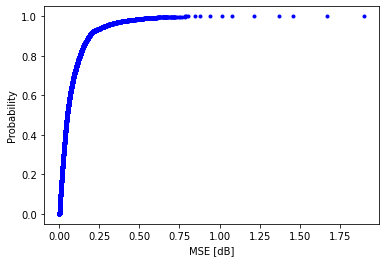

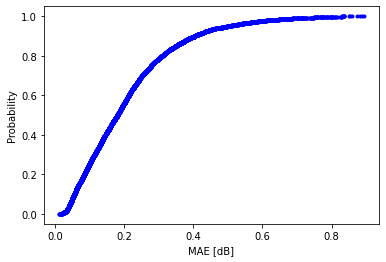

In [22]:
mean_squared_error_store = []
mean_absolute_error_store = []
for i in range(10000):
    mean_squared_error_store.append(mean_squared_error(y_predicted_inverted[i], Y[i]))
    mean_absolute_error_store.append(mean_absolute_error(y_predicted_inverted[i], Y[i]))
x_mse = np.sort(mean_squared_error_store)
x_mae = np.sort(mean_absolute_error_store)
y = np.arange(1, len(x_mse)+1)/len(x_mse)
print(f'90th percentile MSE = {x_mse[9000]}dB')
print(f'90th percentile MAE = {x_mae[9000]}dB')
print(f'Average MSE = {np.mean(x_mse)}')
print(f'Average MAE = {np.mean(x_mae)}')
CDF_plot(x_mse, y, 'CDF_tuned_ANN_MSE', 'MSE')
CDF_plot(x_mae, y, 'CDF_tuned_ANN_MAE', 'MAE')

# Bar plot

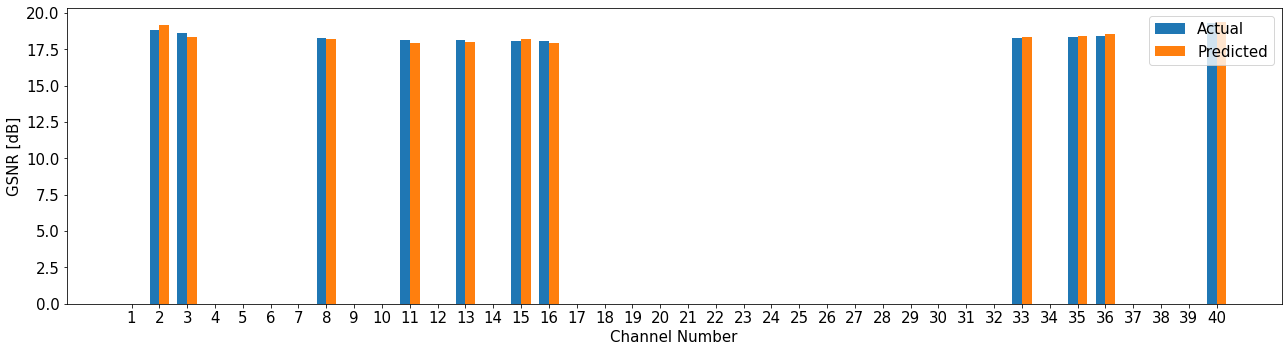

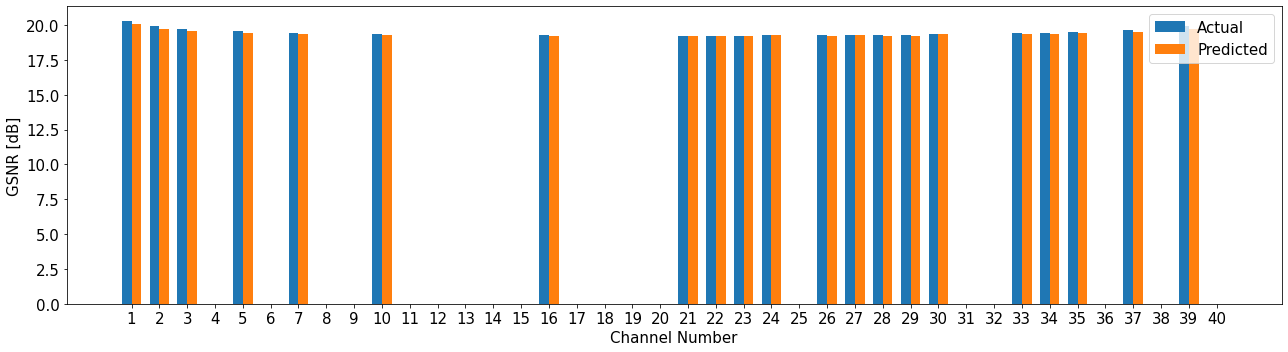

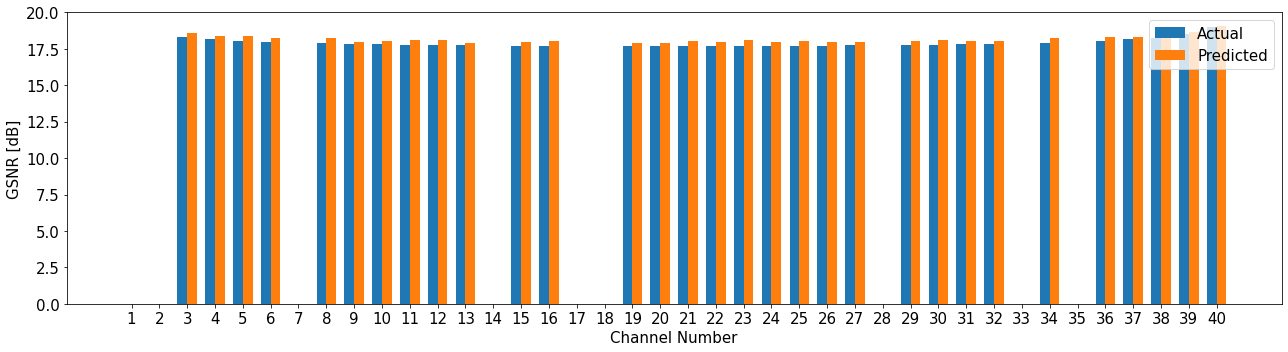

In [23]:
def barplot(index):
    y_actual = Y[index] * X[index][1:]
    y_predicted = y_predicted_inverted[index] * X[index][1:]
    
    labels = [i for i in range(1,41)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(18,5))
    # plt.figure(figsize=(25,5))
    rects1 = ax.bar(x - width/2, y_actual, width, label='Actual')
    rects2 = ax.bar(x + width/2, y_predicted, width, label='Predicted')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GSNR [dB]', fontsize=15)
    ax.set_xlabel('Channel Number', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yticklabels(labels, fontsize=12)
    ax.legend(fontsize=15, loc='upper right')

    fig.tight_layout()

    plt.savefig(f'{data_path}/Figures/tuned_channel_bar_chart_{index}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

barplot(2500)
barplot(5100)
barplot(7500)